In [2]:
from datasets import load_dataset
from transformers import MarianMTModel, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import evaluate
import csv
import re

In [2]:
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [3]:
model_marianMT = "Helsinki-NLP/opus-mt-en-mul"
tokenizer = AutoTokenizer.from_pretrained(model_marianMT,use_fast=False)

c:\Users\M-S-I\anaconda3\envs\ta-jacob\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
# Text Normalisation is to make data more consistent. 
def normalize_text(text):
    text = text.lower()  # Lowercase
    # text = re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters (except whitespace)
    # text = re.sub(r"\s+", " ", text)  # Replace excess whitespace with single space
    return text

prefix = ">>ind<< "
source_lang = "en"
target_lang = "id"
def preprocess(data):
  # Splitting english and indonesian
  inputs = [prefix + normalize_text(dt[source_lang]) for dt in data["translation"]]
  targets = [normalize_text(dt[target_lang]) for dt in data["translation"]]
  model_inputs = tokenizer(inputs, truncation=True)

  # Setup the tokenizer for targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tokenized_datasets = raw_datasets.map(preprocess, batched=True)

In [5]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)

In [4]:
model = MarianMTModel.from_pretrained(model_marianMT)
model = model.cuda()

In [7]:
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(64110, 512, padding_idx=64109)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(64110, 512, padding_idx=64109)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [6]:
import transformers
transformers.MarianConfig

transformers.models.marian.configuration_marian.MarianConfig

In [7]:
# Hyperparameter Fine-Tuning
args = Seq2SeqTrainingArguments(
   f"opus-mt-en-id-finetuned-en-to-id",
   evaluation_strategy = "epoch",
   save_strategy= "epoch",
   learning_rate=2e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   weight_decay=0.01,
   save_total_limit=10,
   num_train_epochs=10,
   predict_with_generate=True,
)

In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [9]:
metric = evaluate.load("sacrebleu")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
   preds = [pred.strip() for pred in preds]
   labels = [[label.strip()] for label in labels]
   return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    prediction_lens = [np.count_nonzero(pred!= tokenizer.pad_token_id) for pred in preds]
    result = {'bleu' : result['score']}
    result["gen_len"] = np.mean(prediction_lens)
    result["meteor"] = meteor_result["meteor"]
    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
trainer = Seq2SeqTrainer(
   model,
   args,
   train_dataset=train_dataset,
   eval_dataset=eval_dataset,
   data_collator=data_collator,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics
)
trainer.train()

  0%|          | 0/312500 [00:00<?, ?it/s]

{'loss': 1.9466, 'grad_norm': 6.141280174255371, 'learning_rate': 1.9968e-05, 'epoch': 0.02}
{'loss': 1.9027, 'grad_norm': 5.862027645111084, 'learning_rate': 1.9936000000000004e-05, 'epoch': 0.03}
{'loss': 1.8502, 'grad_norm': 5.524040699005127, 'learning_rate': 1.9904e-05, 'epoch': 0.05}
{'loss': 1.8174, 'grad_norm': 5.075361728668213, 'learning_rate': 1.9872000000000002e-05, 'epoch': 0.06}
{'loss': 1.7807, 'grad_norm': 5.249956130981445, 'learning_rate': 1.9840000000000003e-05, 'epoch': 0.08}
{'loss': 1.7465, 'grad_norm': 5.106915473937988, 'learning_rate': 1.9808e-05, 'epoch': 0.1}
{'loss': 1.7406, 'grad_norm': 4.751320838928223, 'learning_rate': 1.9776000000000002e-05, 'epoch': 0.11}
{'loss': 1.739, 'grad_norm': 5.4596734046936035, 'learning_rate': 1.9744e-05, 'epoch': 0.13}
{'loss': 1.7105, 'grad_norm': 5.610982418060303, 'learning_rate': 1.9712000000000004e-05, 'epoch': 0.14}
{'loss': 1.6851, 'grad_norm': 6.402386665344238, 'learning_rate': 1.968e-05, 'epoch': 0.16}
{'loss': 1.6

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.3957688808441162, 'eval_bleu': 29.3939, 'eval_gen_len': 14.683, 'eval_meteor': 0.5435, 'eval_runtime': 70.4343, 'eval_samples_per_second': 28.395, 'eval_steps_per_second': 0.894, 'epoch': 1.0}
{'loss': 1.4285, 'grad_norm': 4.190369606018066, 'learning_rate': 1.7984000000000003e-05, 'epoch': 1.01}
{'loss': 1.3788, 'grad_norm': 4.473412036895752, 'learning_rate': 1.7952e-05, 'epoch': 1.02}
{'loss': 1.3747, 'grad_norm': 4.170215129852295, 'learning_rate': 1.792e-05, 'epoch': 1.04}
{'loss': 1.3747, 'grad_norm': 7.566856384277344, 'learning_rate': 1.7888000000000002e-05, 'epoch': 1.06}
{'loss': 1.3725, 'grad_norm': 4.440269947052002, 'learning_rate': 1.7856000000000003e-05, 'epoch': 1.07}
{'loss': 1.3808, 'grad_norm': 4.131677627563477, 'learning_rate': 1.7824e-05, 'epoch': 1.09}
{'loss': 1.3823, 'grad_norm': 4.3520355224609375, 'learning_rate': 1.7792000000000002e-05, 'epoch': 1.1}
{'loss': 1.3903, 'grad_norm': 3.9964795112609863, 'learning_rate': 1.7760000000000003e-05, 'e

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.316219687461853, 'eval_bleu': 29.9761, 'eval_gen_len': 14.7355, 'eval_meteor': 0.5502, 'eval_runtime': 67.9005, 'eval_samples_per_second': 29.455, 'eval_steps_per_second': 0.928, 'epoch': 2.0}
{'loss': 1.274, 'grad_norm': 3.4258179664611816, 'learning_rate': 1.5968e-05, 'epoch': 2.02}
{'loss': 1.2897, 'grad_norm': 5.72532320022583, 'learning_rate': 1.5936e-05, 'epoch': 2.03}
{'loss': 1.2804, 'grad_norm': 4.110970973968506, 'learning_rate': 1.5904000000000002e-05, 'epoch': 2.05}
{'loss': 1.2712, 'grad_norm': 4.842513561248779, 'learning_rate': 1.5872e-05, 'epoch': 2.06}
{'loss': 1.2819, 'grad_norm': 4.4976630210876465, 'learning_rate': 1.584e-05, 'epoch': 2.08}
{'loss': 1.2891, 'grad_norm': 4.283275604248047, 'learning_rate': 1.5808000000000002e-05, 'epoch': 2.1}
{'loss': 1.2881, 'grad_norm': 4.180057048797607, 'learning_rate': 1.5776e-05, 'epoch': 2.11}
{'loss': 1.2779, 'grad_norm': 3.884606122970581, 'learning_rate': 1.5744e-05, 'epoch': 2.13}
{'loss': 1.2847, 'grad_no

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2815277576446533, 'eval_bleu': 30.1123, 'eval_gen_len': 14.6005, 'eval_meteor': 0.55, 'eval_runtime': 68.5551, 'eval_samples_per_second': 29.174, 'eval_steps_per_second': 0.919, 'epoch': 3.0}
{'loss': 1.2378, 'grad_norm': 4.003453731536865, 'learning_rate': 1.3984000000000002e-05, 'epoch': 3.01}
{'loss': 1.2047, 'grad_norm': 3.9548914432525635, 'learning_rate': 1.3952000000000001e-05, 'epoch': 3.02}
{'loss': 1.191, 'grad_norm': 3.8514769077301025, 'learning_rate': 1.392e-05, 'epoch': 3.04}
{'loss': 1.2146, 'grad_norm': 3.668750047683716, 'learning_rate': 1.3888000000000002e-05, 'epoch': 3.06}
{'loss': 1.2345, 'grad_norm': 3.934645652770996, 'learning_rate': 1.3856e-05, 'epoch': 3.07}
{'loss': 1.2182, 'grad_norm': 4.558098316192627, 'learning_rate': 1.3824000000000002e-05, 'epoch': 3.09}
{'loss': 1.2323, 'grad_norm': 4.324213981628418, 'learning_rate': 1.3792000000000001e-05, 'epoch': 3.1}
{'loss': 1.2387, 'grad_norm': 3.9315459728240967, 'learning_rate': 1.376e-05, 'epo

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2608836889266968, 'eval_bleu': 30.2639, 'eval_gen_len': 14.6475, 'eval_meteor': 0.5509, 'eval_runtime': 68.6941, 'eval_samples_per_second': 29.115, 'eval_steps_per_second': 0.917, 'epoch': 4.0}
{'loss': 1.1784, 'grad_norm': 4.144091606140137, 'learning_rate': 1.1968000000000001e-05, 'epoch': 4.02}
{'loss': 1.1802, 'grad_norm': 4.566064357757568, 'learning_rate': 1.1936e-05, 'epoch': 4.03}
{'loss': 1.1739, 'grad_norm': 4.146626949310303, 'learning_rate': 1.1904e-05, 'epoch': 4.05}
{'loss': 1.1688, 'grad_norm': 4.037714958190918, 'learning_rate': 1.1872000000000001e-05, 'epoch': 4.06}
{'loss': 1.1805, 'grad_norm': 4.2571330070495605, 'learning_rate': 1.184e-05, 'epoch': 4.08}
{'loss': 1.1776, 'grad_norm': 3.9744274616241455, 'learning_rate': 1.1808000000000001e-05, 'epoch': 4.1}
{'loss': 1.1859, 'grad_norm': 3.870476722717285, 'learning_rate': 1.1776e-05, 'epoch': 4.11}
{'loss': 1.1602, 'grad_norm': 4.041003227233887, 'learning_rate': 1.1744000000000001e-05, 'epoch': 4.13

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2432924509048462, 'eval_bleu': 30.9412, 'eval_gen_len': 14.7385, 'eval_meteor': 0.5586, 'eval_runtime': 71.1326, 'eval_samples_per_second': 28.117, 'eval_steps_per_second': 0.886, 'epoch': 5.0}
{'loss': 1.1565, 'grad_norm': 3.3239006996154785, 'learning_rate': 9.984e-06, 'epoch': 5.01}
{'loss': 1.1337, 'grad_norm': 4.497529029846191, 'learning_rate': 9.952e-06, 'epoch': 5.02}
{'loss': 1.1418, 'grad_norm': 4.502659320831299, 'learning_rate': 9.920000000000002e-06, 'epoch': 5.04}
{'loss': 1.1489, 'grad_norm': 4.083646297454834, 'learning_rate': 9.888000000000001e-06, 'epoch': 5.06}
{'loss': 1.1319, 'grad_norm': 4.22991418838501, 'learning_rate': 9.856000000000002e-06, 'epoch': 5.07}
{'loss': 1.1403, 'grad_norm': 3.6568751335144043, 'learning_rate': 9.824000000000001e-06, 'epoch': 5.09}
{'loss': 1.1374, 'grad_norm': 5.358383655548096, 'learning_rate': 9.792e-06, 'epoch': 5.1}
{'loss': 1.133, 'grad_norm': 3.990845203399658, 'learning_rate': 9.760000000000001e-06, 'epoch': 5

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2404811382293701, 'eval_bleu': 30.5593, 'eval_gen_len': 14.6565, 'eval_meteor': 0.5559, 'eval_runtime': 67.7027, 'eval_samples_per_second': 29.541, 'eval_steps_per_second': 0.931, 'epoch': 6.0}
{'loss': 1.1105, 'grad_norm': 4.60486364364624, 'learning_rate': 7.968e-06, 'epoch': 6.02}
{'loss': 1.095, 'grad_norm': 3.3984508514404297, 'learning_rate': 7.936e-06, 'epoch': 6.03}
{'loss': 1.1076, 'grad_norm': 4.1075897216796875, 'learning_rate': 7.904000000000001e-06, 'epoch': 6.05}
{'loss': 1.1202, 'grad_norm': 4.400280475616455, 'learning_rate': 7.872e-06, 'epoch': 6.06}
{'loss': 1.1123, 'grad_norm': 3.740535020828247, 'learning_rate': 7.840000000000001e-06, 'epoch': 6.08}
{'loss': 1.1227, 'grad_norm': 4.723203659057617, 'learning_rate': 7.808e-06, 'epoch': 6.1}
{'loss': 1.1149, 'grad_norm': 3.8574159145355225, 'learning_rate': 7.776e-06, 'epoch': 6.11}
{'loss': 1.1144, 'grad_norm': 4.152945041656494, 'learning_rate': 7.744e-06, 'epoch': 6.13}
{'loss': 1.1258, 'grad_norm': 

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2294076681137085, 'eval_bleu': 31.3782, 'eval_gen_len': 14.6415, 'eval_meteor': 0.5594, 'eval_runtime': 64.556, 'eval_samples_per_second': 30.981, 'eval_steps_per_second': 0.976, 'epoch': 7.0}
{'loss': 1.1237, 'grad_norm': 3.8468306064605713, 'learning_rate': 5.984000000000001e-06, 'epoch': 7.01}
{'loss': 1.0833, 'grad_norm': 4.135689735412598, 'learning_rate': 5.952e-06, 'epoch': 7.02}
{'loss': 1.0838, 'grad_norm': 3.951345920562744, 'learning_rate': 5.92e-06, 'epoch': 7.04}
{'loss': 1.0962, 'grad_norm': 4.14940881729126, 'learning_rate': 5.888e-06, 'epoch': 7.06}
{'loss': 1.0767, 'grad_norm': 3.8736863136291504, 'learning_rate': 5.856e-06, 'epoch': 7.07}
{'loss': 1.1052, 'grad_norm': 4.364148139953613, 'learning_rate': 5.8240000000000005e-06, 'epoch': 7.09}
{'loss': 1.0966, 'grad_norm': 3.8663880825042725, 'learning_rate': 5.792000000000001e-06, 'epoch': 7.1}
{'loss': 1.0873, 'grad_norm': 4.38188362121582, 'learning_rate': 5.76e-06, 'epoch': 7.12}
{'loss': 1.0964, 'gr

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2265417575836182, 'eval_bleu': 31.0515, 'eval_gen_len': 14.669, 'eval_meteor': 0.5563, 'eval_runtime': 68.3478, 'eval_samples_per_second': 29.262, 'eval_steps_per_second': 0.922, 'epoch': 8.0}
{'loss': 1.0728, 'grad_norm': 3.6236610412597656, 'learning_rate': 3.968e-06, 'epoch': 8.02}
{'loss': 1.0775, 'grad_norm': 3.7580065727233887, 'learning_rate': 3.936e-06, 'epoch': 8.03}
{'loss': 1.0845, 'grad_norm': 4.513148307800293, 'learning_rate': 3.904e-06, 'epoch': 8.05}
{'loss': 1.0756, 'grad_norm': 3.462290048599243, 'learning_rate': 3.872e-06, 'epoch': 8.06}
{'loss': 1.0622, 'grad_norm': 3.2445437908172607, 'learning_rate': 3.8400000000000005e-06, 'epoch': 8.08}
{'loss': 1.0761, 'grad_norm': 3.6360769271850586, 'learning_rate': 3.8080000000000006e-06, 'epoch': 8.1}
{'loss': 1.0817, 'grad_norm': 4.152624607086182, 'learning_rate': 3.7760000000000004e-06, 'epoch': 8.11}
{'loss': 1.0723, 'grad_norm': 4.068625450134277, 'learning_rate': 3.7440000000000005e-06, 'epoch': 8.13}


  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2219510078430176, 'eval_bleu': 31.1618, 'eval_gen_len': 14.7, 'eval_meteor': 0.557, 'eval_runtime': 69.4181, 'eval_samples_per_second': 28.811, 'eval_steps_per_second': 0.908, 'epoch': 9.0}
{'loss': 1.0821, 'grad_norm': 3.8082847595214844, 'learning_rate': 1.984e-06, 'epoch': 9.01}
{'loss': 1.0742, 'grad_norm': 4.342185974121094, 'learning_rate': 1.952e-06, 'epoch': 9.02}
{'loss': 1.053, 'grad_norm': 4.264849662780762, 'learning_rate': 1.9200000000000003e-06, 'epoch': 9.04}
{'loss': 1.0643, 'grad_norm': 3.7406303882598877, 'learning_rate': 1.8880000000000002e-06, 'epoch': 9.06}
{'loss': 1.0591, 'grad_norm': 3.7273271083831787, 'learning_rate': 1.856e-06, 'epoch': 9.07}
{'loss': 1.078, 'grad_norm': 4.237172603607178, 'learning_rate': 1.8240000000000002e-06, 'epoch': 9.09}
{'loss': 1.0655, 'grad_norm': 3.702448844909668, 'learning_rate': 1.7920000000000002e-06, 'epoch': 9.1}
{'loss': 1.0549, 'grad_norm': 3.57643985748291, 'learning_rate': 1.76e-06, 'epoch': 9.12}
{'loss':

  0%|          | 0/63 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


{'eval_loss': 1.2222956418991089, 'eval_bleu': 30.7464, 'eval_gen_len': 14.686, 'eval_meteor': 0.5564, 'eval_runtime': 68.7559, 'eval_samples_per_second': 29.088, 'eval_steps_per_second': 0.916, 'epoch': 10.0}
{'train_runtime': 21453.4727, 'train_samples_per_second': 466.125, 'train_steps_per_second': 14.566, 'train_loss': 1.209914453515625, 'epoch': 10.0}


TrainOutput(global_step=312500, training_loss=1.209914453515625, metrics={'train_runtime': 21453.4727, 'train_samples_per_second': 466.125, 'train_steps_per_second': 14.566, 'total_flos': 8.708477238116352e+16, 'train_loss': 1.209914453515625, 'epoch': 10.0})

In [11]:
trainer.save_model('model/opus-mt-en-id-finetuned-en-to-id')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[64109]], 'forced_eos_token_id': 0}


In [12]:
log_history = pd.DataFrame(trainer.state.log_history)
bleu_log = log_history["eval_bleu"].dropna().to_list()
meteor_log = log_history["eval_meteor"].dropna().to_list()
eval_log = log_history["eval_loss"].dropna().to_list()

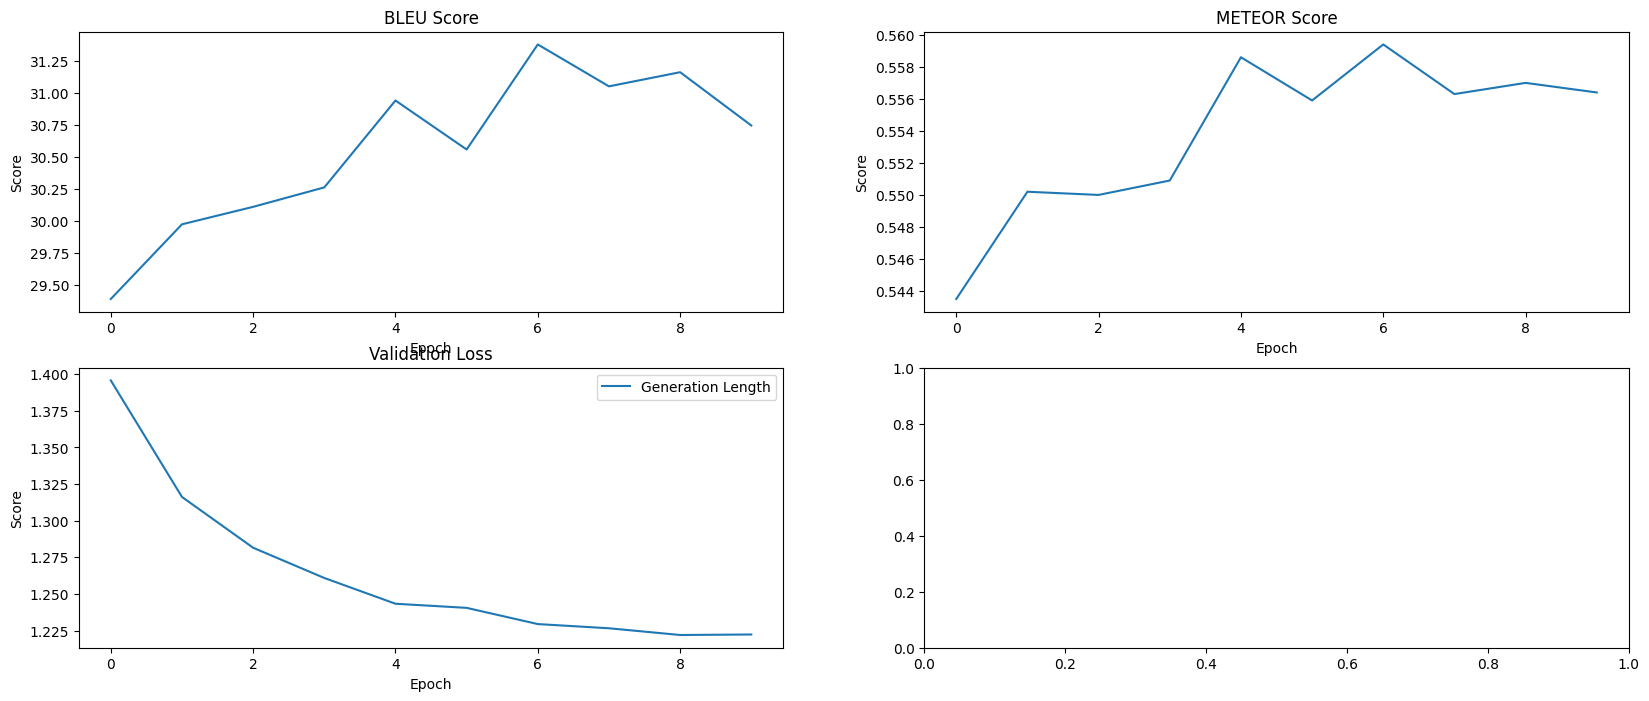

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20,8))
plt.subplot(2, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(range(len(meteor_log)), meteor_log, label='METEOR Score')
plt.title("METEOR Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [14]:
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open('marianMT.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)